In [15]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.configs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
region = 'CIO'
file = merged_pf_stats_file(region)
df = pd.read_csv(file, index_col=0)
basin_id = (abs(df['mean_latitude'])>=0) & (df['mean_longitude']<np.inf)
df = df.where(basin_id).dropna()

In [14]:
df.mean_longitude.min()

55.0732536315918

# Some basic stats of observations distributions

Text(0.5, 1.0, 'Observation Freq WMP [%]')

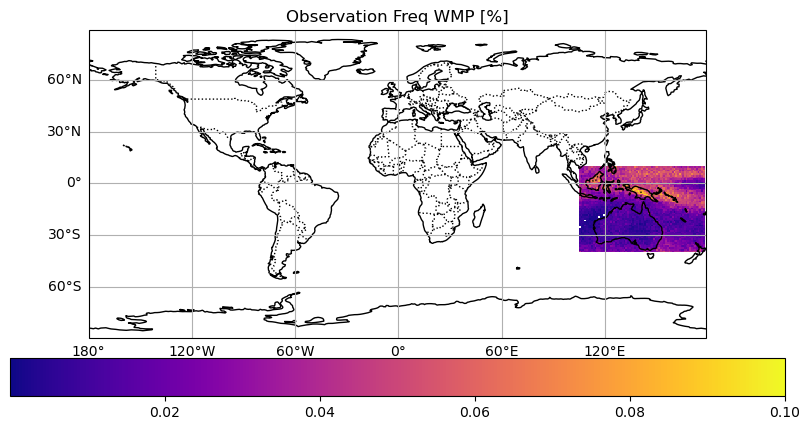

In [101]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

lat_bins = np.arange(-90, 90, 1)  # Create 18 bins (10-degree intervals)
lon_bins = np.arange(-180, 180, 1)  # Create 36 bins (10-degree intervals)

hist, lat_edges, lon_edges = np.histogram2d(df['mean_latitude'], df['mean_longitude'], bins=[lat_bins, lon_bins])
hist = 100*(hist/hist.sum())
# setup map
# ax.set_extent([30, 95, -6, 6], crs=ccrs.PlateCarree())  # Focus on the region of interest
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

# Define meshgrid for latitude and longitude edges
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2  # Calculate bin centers for longitude
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2  # Calculate bin centers for latitude
lon_grid, lat_grid = np.meshgrid(lon_centers, lat_centers)

# Plot the frequency histogram using pcolormesh
cmap = plt.cm.plasma.copy()
norm = colors.Normalize(vmin=1e-10, vmax=0.1)
cmap.set_under('white')
frequency_plot = ax.pcolormesh(lon_grid, lat_grid, hist, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
# Add a colorbar
cbar = plt.colorbar(frequency_plot, orientation='horizontal', ax=ax, pad=0.05)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

ax.set_title(f'Observation Freq {region} [%]')

In [3]:
df

pf_filename   observation_time  \
0     /home/disk/tc/pangulo/gpm_pf/WMP/2015/08/pf_00...  20150801_14:22:15   
1     /home/disk/tc/pangulo/gpm_pf/WMP/2015/08/pf_00...  20150802_00:20:55   
2     /home/disk/tc/pangulo/gpm_pf/WMP/2015/08/pf_00...  20150802_20:16:53   
3     /home/disk/tc/pangulo/gpm_pf/WMP/2015/08/pf_00...  20150803_11:15:35   
4     /home/disk/tc/pangulo/gpm_pf/WMP/2015/08/pf_00...  20150804_10:13:35   
...                                                 ...                ...   
2178  /home/disk/tc/pangulo/gpm_pf/WMP/2020/12/pf_28...  20201222_11:11:47   
2179  /home/disk/tc/pangulo/gpm_pf/WMP/2020/12/pf_28...  20201219_12:13:11   
2180  /home/disk/tc/pangulo/gpm_pf/WMP/2020/12/pf_29...  20201215_14:06:34   
2181  /home/disk/tc/pangulo/gpm_pf/WMP/2020/12/pf_30...  20201231_19:32:39   
2182  /home/disk/tc/pangulo/gpm_pf/WMP/2020/12/pf_31...  20201231_19:32:39   

      mean_latitude  mean_longitude  precipitation_centroid_latitude  \
0         -0.298781      105.206100                        -0.306830   
1        -10.175630      129.428574                       -10.150165   
2        -39.345928      169.426300                       -39.421037   
3        -35.655945      163.757980                       -35.700762   
4        -39.726315      175.624344                       -39.694190   
...             ...             ...                              ...   
2178       9.665322      148.021774                         9.695586   
2179       5.910000      148.279999                         5.912161   
2180       8.709523      135.210709                         8.724554   
2181       7.433914      166.927383                         7.361085   
2182       7.622222      166.218887                         7.632007   

      precipitation_centroid_longitude  num_pixels  num_conv_pixels  \
0                           105.199658          41                0   
1                           129.375823         119              119   
2                           169.489721        1203               25   
3                           163.950219        2852              614   
4                           175.609434          76                0   
...                                ...         ...              ...   
2178                        148.015276          62               44   
2179                        148.252048          45               33   
2180                        135.221889          42               30   
2181                        166.969989         115               87   
2182                        166.203558          45               37   

      num_strat_pixels  num_1mmhr_pixels  ...  num_2mmhr_pixels  \
0                   37                 1  ...                 0   
1                    0                63  ...                47   
2                 1145               552  ...               324   
3                 2088              1912  ...              1486   
4                   74                19  ...                 6   
...                ...               ...  ...               ...   
2178                18                35  ...                19   
2179                12                30  ...                23   
2180                12                26  ...                13   
2181                28                64  ...                40   
2182                 8                23  ...                16   

      max_2mmhr_size  num_5mmhr_pixels  max_5mmhr_size  num_10mmhr_pixels  \
0                  0                 0               0                  0   
1                 11                14               4                  5   
2                107                66               9                  6   
3               1131               896             321                373   
4                  2                 0               0                  0   
...              ...               ...             ...                ...   
2178               9                 8       

In [102]:
# observation times
fig, ax = plt.subplots()
time_diff = pd.to_timedelta(df['mean_longitude'] / 15, unit='h')
solar_time = pd.to_datetime(df['observation_time'], format='%Y%m%d_%H:%M:%S') + time_diff
solar_time.dt.hour.hist(
    ax=ax,
    bins=np.arange(0, 25, 1),
    histtype='step'
)
ax.set_xlabel('Local Solar Hour')
ax.set_ylabel('Counts');
ax.set_title(f'Local GPM PF Observation Times, {region}')

Text(0.5, 1.0, 'Local GPM PF Observation Times, WMP')

Text(0.5, 1.0, 'Local GPM PF Observation Times, WMP')

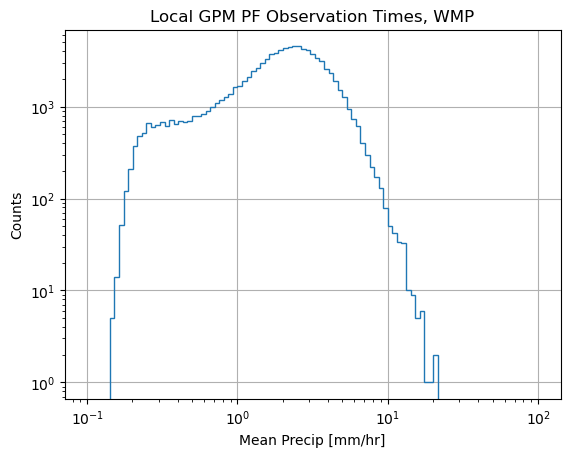

In [103]:
fig, ax = plt.subplots()
mean_pr = df['total_precip']/df['num_pixels']
mean_pr.hist(
    ax=ax, 
    bins=np.logspace(-1, 2, 100),
    histtype='step'
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Mean Precip [mm/hr]')
ax.set_ylabel('Counts')
ax.set_title(f'Local GPM PF Observation Times, {region}')